### Imports

In [416]:
from matplotlib_venn import venn2 
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
from sklearn.metrics import silhouette_score
from sklearn.model_selection import RandomizedSearchCV
from tqdm import tqdm
from utils.utils import *

import hdbscan
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd
import sys

%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 1.54 ms (started: 2023-05-30 01:46:03 -05:00)


### Parameters

In [417]:
import json
  
# Opening JSON file
file = open("parameters.json")
params = json.load(file)

dir = os.path.dirname(os.getcwd())
print(dir)

method = params["method"][params["method_idx"]]
print("Method:\t\t", method)

group = params["group"][params["group_idx"]]
print("Group:\t\t", group)

subgroups = [str(k + 1) for k in range(group[1])]
print("Subgroup:\t", subgroups)

dimensions = params["dimensions"]
dimension = dimensions[0]
print("Dimensions:\t", dimensions)

/home/ealvarez/Project/GNN_Filter
Method:		 dgi
Group:		 ['pck1^', 2]
Subgroup:	 ['1', '2']
Dimensions:	 [3]
time: 2.3 ms (started: 2023-05-30 01:46:03 -05:00)


### Read graphs

In [418]:
dir_ = os.path.dirname(os.getcwd())
print(dir_)

/home/ealvarez/Project/GNN_Filter
time: 1.05 ms (started: 2023-05-30 01:46:03 -05:00)


In [419]:
# Load dataset Groups
df1 = pd.read_csv("{}/input/Edwin_proyecto2/{}.csv".format(dir_, "int1"), delimiter="|")
df2 = pd.read_csv("{}/input/Edwin_proyecto2/{}.csv".format(dir_, "int2"), delimiter="|")
df3 = pd.read_csv("{}/input/Edwin_proyecto2/{}.csv".format(dir_, "int3"), delimiter="|")
df4 = pd.read_csv("{}/input/Edwin_proyecto2/{}.csv".format(dir_, "int4"), delimiter="|")
# df5_ = pd.read_csv("{}/inputs/Edwin_proyecto2/{}.csv".format(dir, "int5"), delimiter="|")

""" df1 = pd.read_csv("{}/inputs/SecondDataset/{}.csv".format(dir, "intensities1"), delimiter="|")
df2 = pd.read_csv("{}/inputs/SecondDataset/{}.csv".format(dir, "intensities2"), delimiter="|")
df3 = pd.read_csv("{}/inputs/SecondDataset/{}.csv".format(dir, "intensities3"), delimiter="|")
df4 = pd.read_csv("{}/inputs/SecondDataset/{}.csv".format(dir, "intensities4"), delimiter="|")
df5_ = pd.read_csv("{}/inputs/SecondDataset/{}.csv".format(dir, "intensities5"), delimiter="|") """

print(df1.shape)
print(df2.shape)
print(df3.shape)
print(df4.shape)
# print(df5_.shape)

(6245, 102)
(6245, 72)
(6245, 97)
(6245, 137)
time: 173 ms (started: 2023-05-30 01:46:03 -05:00)


In [420]:
# concat
# df_join_raw = pd.concat([df1.iloc[:,1:], df2.iloc[:, 2:], df3.iloc[:, 2:], df4.iloc[:, 2:], df5.iloc[:, 2:]], axis=1)
df_join_raw = pd.concat([df1.iloc[:, 1:], df2.iloc[:, 2:], df3.iloc[:, 2:], df4.iloc[:, 2:]], axis=1)
df_join_raw.set_index("ionMz", inplace=True)

print(df_join_raw.shape)
df_join_raw

(6245, 400)


,0001 / zwf1^ 3.4,0002 / zwf1^ 3.4,0003 / zwf1^ 3.4,0004 / zwf1^ 3.4,0005 / zwf1^ 3.4,0006 / zwf1^ 3.4,0007 / zwf1^ 3.4,0008 / zwf1^ 3.4,0009 / zwf1^ 3.4,0010 / zwf1^ 3.4,...,0951 / WT 3.4,0952 / WT 3.4,0953 / WT 3.4,0954 / WT 3.4,0955 / WT 3.4,0956 / WT 3.4,0957 / WT 3.4,0958 / WT 3.4,0959 / WT 3.4,0960 / WT 3.4
ionMz,,,,,,,,,,,,,,,,,,,,,
59.0049,1,47,508,360,675,232,59,345,346,504,...,45,817,32,307,410,716,228,187,361,952
59.0137,53182,57902,51861,62812,54291,54395,59054,52547,57544,63538,...,45747,39677,47205,38697,54320,62610,47283,49927,43632,48511
59.0291,2151,2102,2334,2864,2393,2246,2331,1954,2310,2528,...,1852,1717,1830,1660,2006,2539,2103,2276,1643,2522
59.0370,83,174,366,1134,693,464,235,479,443,691,...,225,349,185,429,186,278,364,368,115,887
59.0453,1,1,51,642,493,143,11,227,160,154,...,60,293,1,336,65,142,1,182,10,684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996.5509,2470,2435,2465,2727,2773,2157,2168,2623,2256,2636,...,1866,1834,1669,674,2533,1017,2983,1814,2160,1899
996.7096,3366,3241,2909,3469,3538,3010,3031,2872,2709,3601,...,1748,1419,1160,621,1758,1474,1973,1023,1769,1629
997.5542,2818,2335,1807,1679,2222,2070,2158,1835,2087,2784,...,1168,828,1162,1103,2253,1419,2306,1542,827,1433


time: 24 ms (started: 2023-05-30 01:46:04 -05:00)


In [421]:
# get nodes
# common_nodes = list(df_join_raw.index)
common_nodes = set([
# 59.0137,
71.0139,
# 74.0249,
85.0296,
87.0086,
88.0405,
89.0245,
# 101.0243,
# 102.0562,
# 109.0407,
115.0038,
# 117.0195,
118.051,
118.9807,
122.0247,
# 129.0192,
130.0506,
# 130.0875,
131.0355,
131.0824,
132.0303,
133.014,
135.0311,
145.0144,
145.0984,
146.0458,
147.0297,
151.0403,
152.0354,
154.062,
166.0506,
166.9758,
# 171.0302,
173.0095,
173.0454,
179.0561,
184.0021,
218.1033,
249.0552,
259.0227,
# 266.0886,
316.2857,
323.0277,
338.9889,
346.0558,
362.0509,
367.0185,
# 388.9441,
401.0173,
426.0221,
489.9937,
505.9889,
521.984,
606.0744,
664.117,
766.1076,
784.1495,
808.118,
808.118
])

time: 2.07 ms (started: 2023-05-30 01:46:04 -05:00)


In [422]:
# GNN method STD
df_edge_embeddings_join_filter_count_weight_std_avg = pd.read_csv("{}/output_edges/edges_filter_weight_std_avg/{}_{}_edge-filter-weight-std-avg_{}_{}.csv".format(dir, method, group[0], dimension, "L2"))
df_edge_embeddings_join_filter_count_weight_std_avg

G = nx.from_pandas_edgelist(df_edge_embeddings_join_filter_count_weight_std_avg, "source", "target", edge_attr=["weight"])
graph_detail(G)

nodes_gnn = set(list(G.nodes()))

Num. nodes: 5089
Num. edges: 434826

time: 972 ms (started: 2023-05-30 01:46:04 -05:00)


In [423]:
# Greedy STD
df_edges_filter = pd.read_csv("{}/output_greedy/edges_filter/greedy_{}_edge-filter-std.csv".format(dir, group[0]))

G11 = nx.from_pandas_edgelist(df_edges_filter, "source", "target", edge_attr=["weight"])
graph_detail(G11)
nodes_std = set(list(G11.nodes()))

G11_ = nx.read_gexf("{}/output_greedy/graphs_filter/greedy_{}_graph-filter-std.gexf".format(dir, group[0]), node_type=float)
print(G11_.number_of_nodes(), G11_.number_of_edges())
nodes_std_ = set(list(G11_.nodes()))

Num. nodes: 5677
Num. edges: 732148

5677 732148
time: 15.9 s (started: 2023-05-30 01:46:05 -05:00)


In [424]:
# Greedy STD-ANOVA
df_edges_filter = pd.read_csv("{}/output_greedy/edges_filter/greedy_{}_edge-filter-std-anova.csv".format(dir, group[0]))

G12 = nx.from_pandas_edgelist(df_edges_filter, "source", "target", edge_attr=["weight"])
graph_detail(G12)

nodes_std_anova = set(list(G12.nodes()))

G12_ = nx.read_gexf("{}/output_greedy/graphs_filter/greedy_{}_graph-filter-std-anova.gexf".format(dir, group[0]), node_type=float)
print(G12_.number_of_nodes(), G12_.number_of_edges())
nodes_std_anova_ = set(list(G12_.nodes()))

Num. nodes: 4651
Num. edges: 473180

4691 473180
time: 9.74 s (started: 2023-05-30 01:46:21 -05:00)


In [425]:
# Greedy ANOVA
df_edges_filter = pd.read_csv("{}/output_greedy/edges_filter/greedy_{}_edge-filter-anova.csv".format(dir, group[0]))

G21 = nx.from_pandas_edgelist(df_edges_filter, "source", "target")
graph_detail(G21)

nodes_anova = set(list(G21.nodes()))

G21_ = nx.read_gexf("{}/output_greedy/graphs_filter/greedy_{}_graph-filter-anova.gexf".format(dir, group[0]), node_type=float)
G21_.number_of_nodes(), G21_.number_of_edges()
nodes_anova_ = set(list(G21_.nodes()))

Num. nodes: 4674
Num. edges: 524844

time: 9.04 s (started: 2023-05-30 01:46:31 -05:00)


In [426]:
# Greedy ANOVA-STD
df_edges_filter = pd.read_csv("{}/output_greedy/edges_filter/greedy_{}_edge-filter-anova-std.csv".format(dir, group[0]))

G22 = nx.from_pandas_edgelist(df_edges_filter, "source", "target", edge_attr=["weight"])
graph_detail(G22)

nodes_anova_std = set(list(G22.nodes()))

G22_ = nx.read_gexf("{}/output_greedy/graphs_filter/greedy_{}_graph-filter-anova-std.gexf".format(dir, group[0]), node_type=float)
G22_.number_of_nodes(), G22_.number_of_edges()
nodes_anova_std_ = set(list(G22_.nodes()))

Num. nodes: 4651
Num. edges: 473180

time: 11.1 s (started: 2023-05-30 01:46:40 -05:00)


In [427]:
def ope_set(s1, s2):
    a = s1 - s2
    b = s1 & s2
    c = s2 - s1
    return a, b, c

time: 755 µs (started: 2023-05-30 01:46:51 -05:00)


---

### Get common edges

In [428]:
len(common_nodes)

47

time: 2.1 ms (started: 2023-05-30 01:46:51 -05:00)


2 45 5044


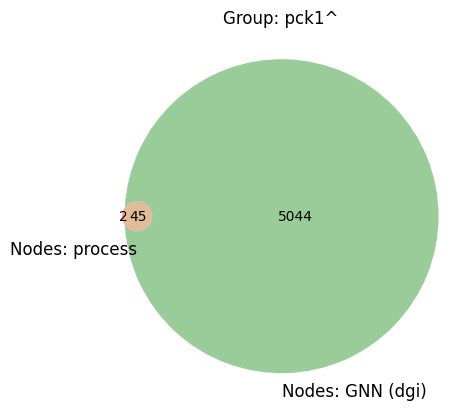

time: 65.8 ms (started: 2023-05-30 01:46:51 -05:00)


In [429]:
a, b, c = ope_set(common_nodes, nodes_gnn)
print(len(a),len(b), len(c))
venn2(subsets=(len(a), len(c), len(b)), set_labels=("Nodes: process", "Nodes: GNN ({})".format(method)))
plt.title("Group: {}".format(group[0]))
plt.show()

0 47 5630


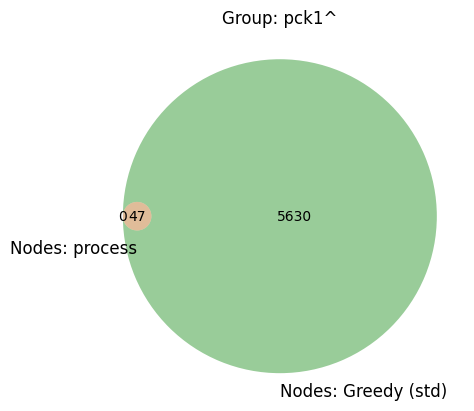

time: 77 ms (started: 2023-05-30 01:46:51 -05:00)


In [430]:
a, b, c = ope_set(common_nodes, nodes_std_)
print(len(a),len(b), len(c))
venn2(subsets=(len(a), len(c), len(b)), set_labels=("Nodes: process", "Nodes: Greedy (std)"))
plt.title("Group: {}".format(group[0]))
plt.show()

7 40 4651


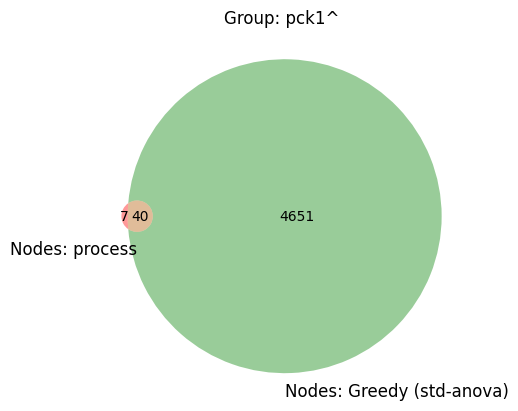

time: 71.8 ms (started: 2023-05-30 01:46:51 -05:00)


In [431]:
a, b, c = ope_set(common_nodes, nodes_std_anova_)
print(len(a),len(b), len(c))
venn2(subsets=(len(a), len(c), len(b)), set_labels=("Nodes: process", "Nodes: Greedy (std-anova)"))
plt.title("Group: {}".format(group[0]))
plt.show()

7 40 4634


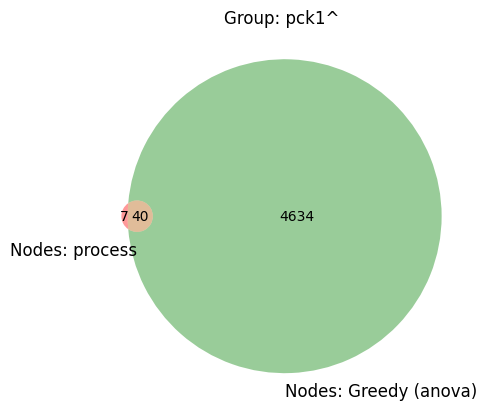

time: 72.5 ms (started: 2023-05-30 01:46:51 -05:00)


In [432]:
a, b, c = ope_set(common_nodes, nodes_anova_)
print(len(a),len(b), len(c))
venn2(subsets=(len(a), len(c), len(b)), set_labels=("Nodes: process", "Nodes: Greedy (anova)"))
plt.title("Group: {}".format(group[0]))
plt.show()

7 40 4611


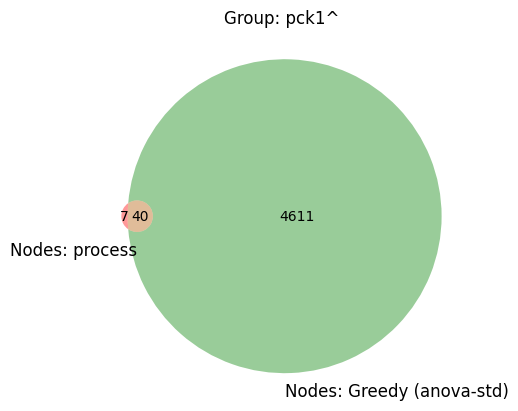

time: 63.2 ms (started: 2023-05-30 01:46:52 -05:00)


In [433]:
a, b, c = ope_set(common_nodes, nodes_anova_std_)
print(len(a),len(b), len(c))
venn2(subsets=(len(a), len(c), len(b)), set_labels=("Nodes: process", "Nodes: Greedy (anova-std)"))
plt.title("Group: {}".format(group[0]))
plt.show()

---

986 4691 0


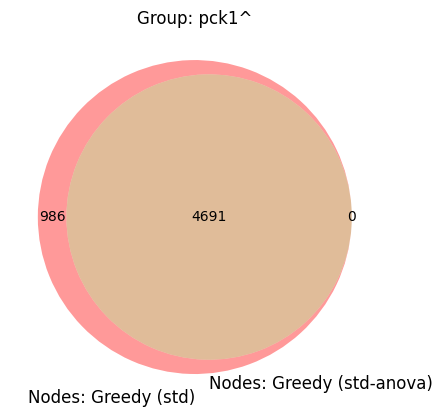

time: 64.4 ms (started: 2023-05-30 01:46:52 -05:00)


In [434]:
a, b, c = ope_set(nodes_std_, nodes_std_anova_)
print(len(a),len(b), len(c))
venn2(subsets=(len(a), len(c), len(b)), set_labels=("Nodes: Greedy (std)", "Nodes: Greedy (std-anova)"))
plt.title("Group: {}".format(group[0]))
plt.show()

23 4651 0


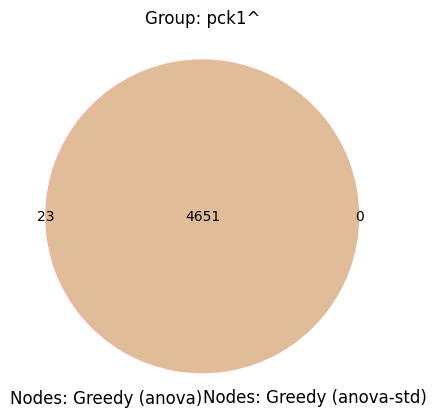

time: 89.6 ms (started: 2023-05-30 01:46:52 -05:00)


In [435]:
a, b, c = ope_set(nodes_anova_, nodes_anova_std_)
print(len(a),len(b), len(c))
venn2(subsets=(len(a), len(c), len(b)), set_labels=("Nodes: Greedy (anova)", "Nodes: Greedy (anova-std)"))
plt.title("Group: {}".format(group[0]))
plt.show()